<div>
<img src="https://sergeyprokudin.github.io/dpf/dpf_files/single_scan_animation.png"/>
</div>

# Dynamic Point Fields: Single Scan Animation

**Author**: [Sergey Prokudin](https://scholar.google.com/citations?user=xSywCzAAAAAJ).
[[Project Page](https://sergeyprokudin.github.io/dpf/)]
[[Paper](https://arxiv.org/abs/2304.02626)]
[[Video](https://www.youtube.com/watch?v=i-9eAgS8HEA)]
[[GitHub](https://github.com/sergeyprokudin/dpf)]

This notebook contains an example workflow for animating a 3D scan using SMPL vertices as a driving signal. This corresponds to the Section 4.3 of [the original paper](https://arxiv.org/abs/2304.02626).

### Main steps:

1. Download the source scan, source and target SMPL vertices.
2. Define the [SIREN](https://www.vincentsitzmann.com/siren/) deformation network;
3. Optimise deformation network based on the combination of losses: SMPL vertex supervision loss, AIAP regularization;
4. Visualise the deformed source mesh;


### Notes

* Please report issues on the [GitHub issue tracker](https://github.com/sergeyprokudin/dpf/issues).

* **Other experiments from our ICCV paper**: [point cloud optimisation](https://colab.research.google.com/github//sergeyprokudin/dpf/blob/main/colab_notebooks/Static_Surface_Reconstruction_with_Optimised_Clouds.ipynb), [surface registration](https://colab.research.google.com/github//sergeyprokudin/dpf/blob/main/colab_notebooks/Learning_Surface_Deformations.ipynb);

If you find this work useful, please consider citing:
```bibtex
@article{prokudin2023dynamic,
                  title={Dynamic Point Fields},
                  author={Prokudin, Sergey and Ma, Qianli and Raafat, Maxime and Valentin, Julien and Tang, Siyu},
                  journal={arXiv preprint arXiv:2304.02626},
                  year={2023}
                }
```


In [ ]:
# @title Install dependencies: pytorch3d, point-cloud-utils, trimesh, pymeshlab

import sys
import torch
pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
version_str="".join([
    f"py3{sys.version_info.minor}_cu",
    torch.version.cuda.replace(".",""),
    f"_pyt{pyt_version_str}"
])

!pip install fvcore iopath
!pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
!pip install trimesh
!pip install point-cloud-utils
!pip3 install pymeshlab

In [ ]:
# @title Download the source and target mesh, SMPL vertices

!wget https://polybox.ethz.ch/index.php/s/Io8wsbLokCQXqBt/download -O avatar_animation.zip
!unzip avatar_animation.zip

In [95]:
# @title Point rendering, saving clouds
import torch
import point_cloud_utils as pcu
import numpy as np
import torch
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    PerspectiveCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PerspectiveCameras,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)


DEVICE = 'cuda'
POINT_RADIUS = 0.007
IMAGE_SIZE = 1024
POINTS_PER_PIXEL = 50


def normalise_verts(V, V_scale=None, V_center=None):

  # Normalize mesh

  if V_scale is not None and V_center is not None:

    V = V - V_center
    V *= V_scale

  else:

    V_max, _ = torch.max(V, dim=0)
    V_min, _ = torch.min(V, dim=0)
    V_center = (V_max + V_min) / 2.
    V = V - V_center

    # Find the max distance to origin
    max_dist = torch.sqrt(torch.max(torch.sum(V**2, dim=-1)))
    V_scale = (1. / max_dist)
    V *= V_scale

  return V, V_scale, V_center


def normals_to_rgb(normals: torch.Tensor) -> torch.Tensor:
  """
  Convert mesh normals to RGB color representation.

  Args:
      normals (torch.Tensor): Mesh normals.

  Returns:
      torch.Tensor: RGB colors based on the normals.
  """
  return torch.abs(normals * 0.5 + 0.5)


def get_point_renderer(image_size, radius=0.05, points_per_pixel=50):

  raster_settings = PointsRasterizationSettings(
      image_size=image_size,
      radius = radius,
      points_per_pixel = points_per_pixel
      )

  rasterizer = PointsRasterizer(cameras=FoVOrthographicCameras(),
                                raster_settings=raster_settings)
  renderer = PointsRenderer(
      rasterizer=rasterizer,
      compositor=AlphaCompositor(background_color=(0, 0, 0))
  )

  return renderer

def get_camera(dist=1, elev=0, azim=0):

  R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)

  cam = PerspectiveCameras(R=R, T=T)

  return cam

def render_points(x, xf, dist=1, elev=0, azim=0,
                  image_size=IMAGE_SIZE,
                  radius=POINT_RADIUS,
                  points_per_pixel=POINTS_PER_PIXEL, scale_val=1.0,
                  device=DEVICE):

  x = x.to(device)
  xf = xf.to(device)
  renderer = get_point_renderer(image_size=image_size, radius=radius, points_per_pixel=points_per_pixel)
  R, T = look_at_view_transform(dist=dist, elev=elev, azim=azim)
  cam = FoVOrthographicCameras(R=R, T=T, scale_xyz=((scale_val, scale_val, scale_val),)).to(device)

  pcl = Pointclouds(points=x.unsqueeze(0), features=xf.unsqueeze(0)).to(device)

  img = renderer(pcl, cameras=cam)[0]

  return img

In [96]:
# we will start with using A pose scan as our source scan

xsrc, nsrc = pcu.load_mesh_vn('/content/source_apose.ply')
xtrg, ntrg = pcu.load_mesh_vn('/content/target.ply')

vsrc = pcu.load_mesh_v('/content/source_apose_vertices.ply')
vtrg = pcu.load_mesh_v('/content/target_vertices.ply')

xsrc = torch.Tensor(xsrc).to(DEVICE)
csrc = normals_to_rgb(torch.Tensor(nsrc))
xtrg = torch.Tensor(xtrg).to(DEVICE)
ctrg = normals_to_rgb(torch.Tensor(ntrg))

vsrc = torch.Tensor(vsrc).to(DEVICE)
vtrg = torch.Tensor(vtrg).to(DEVICE)

# define colors for verts
VRGB_GREEN = torch.zeros([len(vsrc), 3]).to(DEVICE)
VRGB_GREEN[:, 1] = 1

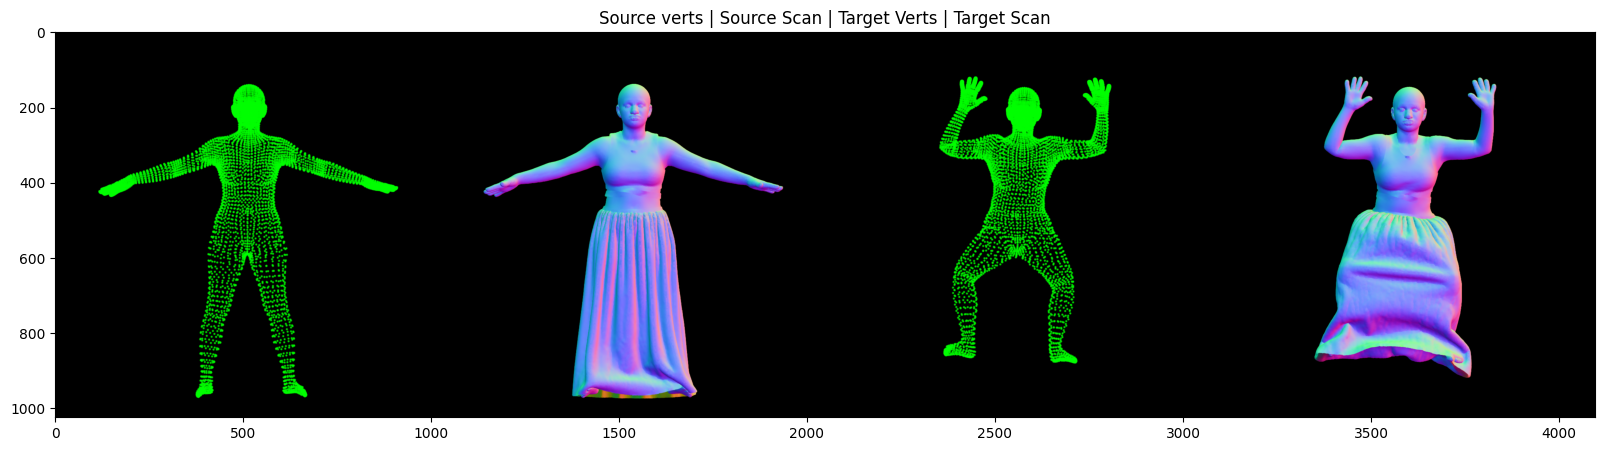

In [98]:
# let's render our source and target scans
import matplotlib.pyplot as plt

yxsrc = render_points(xsrc, csrc).detach().cpu().numpy()
yxtrg = render_points(xtrg, ctrg).detach().cpu().numpy()
yvsrc = render_points(vsrc, VRGB_GREEN).detach().cpu().numpy()
yvtrg = render_points(vtrg, VRGB_GREEN).detach().cpu().numpy()

y = np.hstack([yvsrc, yxsrc, yvtrg, yxtrg]).clip(0,1)

plt.figure(figsize=(20, 5))
plt.title("Source verts | Source Scan | Target Verts | Target Scan")
plt.imshow(y)

In [99]:
# @title Define SIREN deformation model

# https://github.com/vsitzmann/siren

# MIT License

# Copyright (c) 2020 Vincent Sitzmann

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

from torch import nn
import numpy as np

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.

    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a
    # hyperparameter.

    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)

    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords#.requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output #, coords

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [100]:
# @title Define deformation learning function and AIAP loss
from tqdm import tqdm
import torch
from torch.nn.functional import l1_loss
from pytorch3d.ops.knn import knn_points
from pytorch3d.loss.chamfer import chamfer_distance

def aiap_loss(x_canonical, x_deformed, n_neighbors=5):
    """
    Computes the as-isometric-as-possible loss between two sets of points, which measures the discrepancy
    between their pairwise distances.

    Parameters
    ----------
    x_canonical : array-like, shape (n_points, n_dims)
        The canonical (reference) point set, where `n_points` is the number of points
        and `n_dims` is the number of dimensions.
    x_deformed : array-like, shape (n_points, n_dims)
        The deformed (transformed) point set, which should have the same shape as `x_canonical`.
    n_neighbors : int, optional
        The number of nearest neighbors to use for computing pairwise distances.
        Default is 5.

    Returns
    -------
    loss : float
        The AIAP loss between `x_canonical` and `x_deformed`, computed as the L1 norm
        of the difference between their pairwise distances. The loss is a scalar value.
    Raises
    ------
    ValueError
        If `x_canonical` and `x_deformed` have different shapes.
    """

    if x_canonical.shape != x_deformed.shape:
        raise ValueError("Input point sets must have the same shape.")

    _, nn_ix, _ = knn_points(x_canonical.unsqueeze(0),
                             x_canonical.unsqueeze(0),
                             K=n_neighbors,
                             return_sorted=True)

    dists_canonical = torch.cdist(x_canonical[nn_ix], x_canonical[nn_ix])
    dists_deformed = torch.cdist(x_deformed[nn_ix], x_deformed[nn_ix])

    loss = l1_loss(dists_canonical, dists_deformed)

    return loss


# deformation learning
def deform_cloud(model, xsrc, xtrg=None, vsrc=None, vtrg=None,
                 use_aiap=True, use_aiap_inter=True,
                 use_chamfer=True, use_guidance=True,
                 n_chamfer_samples=10**4, n_steps=20000, init_lr=1.0e-4,
                 aiap_weight=1.0e4, aiap_inter_max=1.0,
                 guided_weight=1.0e4, chamfer_weight=1.0e4,
                 iso_n_neighbors=5, eval_every_nth_step=100, device=DEVICE):
  """
  Deform a point cloud using a neural network model.

  Parameters
  ----------
  model : torch.nn.Module
      The neural network model to use for deformation.
  xsrc : numpy.ndarray
      The source point cloud to deform.
  xtrg : numpy.ndarray, optional
      The target point cloud to match (used in chamfer distance loss).
  vsrc : numpy.ndarray, optional
      The source keypoints to use as guidance for deformation.
  vtrg : numpy.ndarray, optional
      The target keypoints to match (used in guided loss).
  use_aiap : bool, optional
      Whether to use AIAP loss (default is True).
  use_aiap_inter : bool, optional
      Whether to use AIAP loss between halfway frames (default is True).
  use_chamfer : bool, optional
      Whether to use chamfer distance loss (default is True).
  use_guidance : bool, optional
      Whether to use guided loss (default is True).
  n_chamfer_samples : int, optional
      The number of points to sample for chamfer distance loss (default is 10**4).
  n_steps : int, optional
      The number of optimization steps (default is 20000).
  init_lr : float, optional
      The initial learning rate for the optimizer (default is 1.0e-4).
  aiap_weight : float, optional
      The weight for AIAP loss (default is 1.0e4).
  aiap_inter_max : float, optional
      The interval for AIAP loss between frames (default is 1.0). Check Section 3.2 for details
  guided_weight : float, optional
      The weight for guided loss (default is 1.0e4).
  chamfer_weight : float, optional
      The weight for chamfer distance loss (default is 1.0e4).
  iso_n_neighbors : int, optional
      The number of neighbors to use for isometric loss (default is 5).
  eval_every_nth_step : int, optional
      The number of steps between evaluations (default is 100).
  device: str, optional
      Device to use for rendering. Defaults to DEVICE.

  """

  model = model.train()
  l1_loss = torch.nn.L1Loss()
  optm = torch.optim.Adam(model.parameters(), lr=init_lr)
  schedm = torch.optim.lr_scheduler.ReduceLROnPlateau(optm, verbose=True, patience=1)

  if use_chamfer and xtrg is None:
    print("no target cloud provided, ignoring...")
    use_chamfer = False

  if use_guidance and vtrg is None:
    print("no keypoints provided, ignoring...")
    use_guidance = False

  guided_loss_total = 0
  chamfer_loss_total = 0
  aiap_loss_total = 0
  total_loss = 0
  n_r = 0

  for i in range(0, n_steps):

    if use_aiap or use_chamfer or use_aiap_inter:
      xbatch_src = torch.Tensor(xsrc[np.random.choice(len(xsrc), n_chamfer_samples, replace=False)]).to(device)
      xbatch_deformed = xbatch_src + model(xbatch_src)

    if use_aiap_inter:
      # additionally enforce isometry between frames
      t = aiap_inter_max * np.random.uniform()
      xbatch_deformed_halfway = xbatch_src + aiap_inter_max*model(xbatch_src)

    loss = 0

    if use_aiap:
      iso_loss = aiap_weight*aiap_loss(xbatch_src, xbatch_deformed, n_neighbors=iso_n_neighbors)
      loss += iso_loss
      aiap_loss_total += float(iso_loss)

    if use_aiap_inter:
      iso_loss += aiap_weight*aiap_loss(xbatch_src, xbatch_deformed_halfway, n_neighbors=iso_n_neighbors)
      loss += iso_loss
      aiap_loss_total += float(iso_loss)

    if use_guidance:
      vsrc_deformed = vsrc + model(vsrc)
      guidance_loss = guided_weight*l1_loss(vsrc_deformed, vtrg)
      loss += guidance_loss
      guided_loss_total += float(guidance_loss)

    if use_chamfer:
      xbatch_trg = torch.Tensor(xtrg[np.random.choice(len(xtrg), n_chamfer_samples, replace=False)]).to(device)
      chamfer_loss = chamfer_weight*chamfer_distance(xbatch_deformed.unsqueeze(0),
                                                     xbatch_trg.unsqueeze(0))[0]
      loss += chamfer_loss
      chamfer_loss_total += float(chamfer_loss)

    total_loss += float(loss)
    n_r += 1

    optm.zero_grad()
    loss.backward()
    optm.step()

    if i % eval_every_nth_step == 0:

      guided_loss_total /= n_r
      aiap_loss_total /= n_r
      chamfer_loss_total /= n_r
      total_loss /= n_r

      schedm.step(float(total_loss))

      print("%05d total loss: %03f, guidl: %03f, chaml. :%03f, AIAP: %03f"
            % (i, total_loss, guided_loss_total, chamfer_loss_total, aiap_loss_total))

      guided_loss_total = 0
      chamfer_loss_total = 0
      aiap_loss_total = 0
      total_loss = 0
      n_r = 0

  guided_loss_total /= n_r
  aiap_loss_total /= n_r
  chamfer_loss_total /= n_r
  total_loss /= n_r

  print("%05d total loss: %03f, guidl: %03f, chaml. :%03f, AIAP: %03f"
            % (i, total_loss, guided_loss_total, chamfer_loss_total, aiap_loss_total))

  return

def deform_mesh(mesh, model):

  vsrc = source_mesh.verts_packed()
  vpred = vsrc + model(vsrc).detach().clone()
  mesh_pred = Meshes(vpred.unsqueeze(0), source_mesh.faces_packed().unsqueeze(0))

  return mesh_pred

In [ ]:
# define our deformation function

model = Siren(in_features=3,
                hidden_features=128,
                hidden_layers=3,
                out_features=3, outermost_linear=True,
                first_omega_0=30, hidden_omega_0=30.).to(DEVICE).train()

# you can adjust the AIAP weight based on your surface data:
# higher values of the AIAP_WEIGHT lead to a
# more isometric (constrained) learned deformation

AIAP_WEIGHT = 1.0e2
GUIDANCE_WEIGHT = 1.0e4

# start training

deform_cloud(model,
             xsrc=xsrc, xtrg=xtrg,
             vsrc=vsrc, vtrg=vtrg,
             init_lr=1.0e-4,
             n_steps=2000,
             aiap_weight=AIAP_WEIGHT,
             guided_weight=GUIDANCE_WEIGHT,
             use_chamfer=False,
             use_guidance=True,
             use_aiap=True,
             use_aiap_inter=True,
             device=DEVICE)

In [102]:
# @title Pymeshlab normal estimation

# https://github.com/cnr-isti-vclab/PyMeshLab/blob/main/docs/filter_list.rst
# https://pymeshlab.readthedocs.io/en/0.2/tutorials/get_mesh_values.html

import pymeshlab

def get_normals_pymeshlab(x,  k=10, smoothiter=0):

  tmp_mesh_path = 'tmp.obj'
  pcu.save_mesh_v(tmp_mesh_path, x)

  ms = pymeshlab.MeshSet()
  ms.load_new_mesh(tmp_mesh_path)
  ms.compute_normal_for_point_clouds(k=k, smoothiter=smoothiter)
  #ms.save_current_mesh(trg_path, save_vertex_normal=True)
  #ms.generate_surface_reconstruction_screened_poisson(depth=8)
  m = ms.current_mesh()

  x = m.vertex_matrix()
  n = m.vertex_normal_matrix()

  return x, n

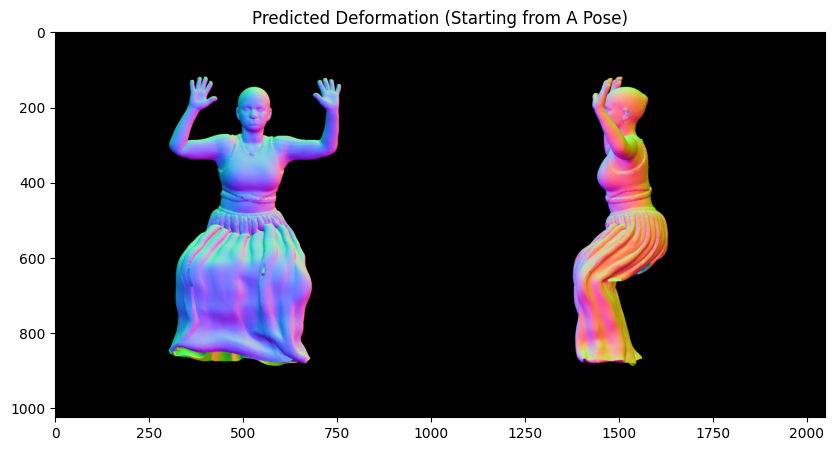

In [103]:
# let's render our predicted deformed cloud

model.eval()

xpred = xsrc + model(xsrc).detach().clone()
xpred, npred = get_normals_pymeshlab(xpred.cpu().numpy(), k=20, smoothiter=0)

# save predicted scan
pcu.save_mesh_vn('predicted_apose.ply', xpred, npred)

xpred = torch.Tensor(xpred).to(DEVICE)
npred = torch.Tensor(npred).to(DEVICE)
npred = -npred  # we might need to flip the normal sign

npred_rgb = normals_to_rgb(npred)

ypred0 = render_points(xpred, npred_rgb, azim=0).detach().cpu().numpy()
ypred1 = render_points(xpred, npred_rgb, azim=90).detach().cpu().numpy()

y = np.hstack([ypred0, ypred1])

plt.figure(figsize=(10, 5))
plt.title("Predicted Deformation (Starting from A Pose)")
plt.imshow(y)

In [ ]:
# @title Compare source, deformed and target scans (A pose case)
# Let's visualise and compare source, predicted, and target scans
y = np.hstack([yvsrc, yxsrc, yvtrg, ypred0, yxtrg]).clip(0,1)

plt.figure(figsize=(25, 5))
plt.title("Source verts | Source Scan | Target Verts | Predicted Deformation | Target Scan")
plt.imshow(y)

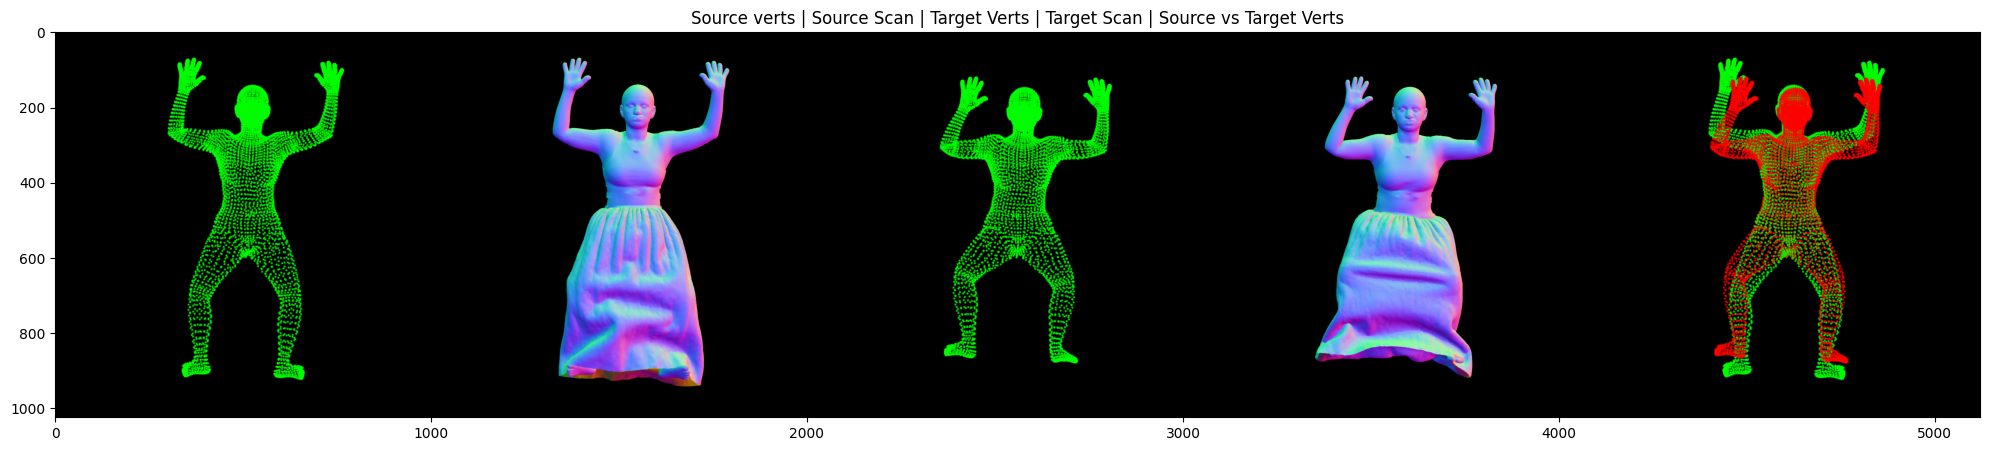

In [106]:
# now, let's start with a closest pose from the ReSynth training set:
# we can see that there is a squatting pose very similar to the target one
# in the training set already

xsrc, nsrc = pcu.load_mesh_vn('/content/source_nearest.ply')
xtrg, ntrg = pcu.load_mesh_vn('/content/target.ply')

vsrc = pcu.load_mesh_v('/content/source_nearest_vertices.ply')
vtrg = pcu.load_mesh_v('/content/target_vertices.ply')

xsrc = torch.Tensor(xsrc).to(DEVICE)
csrc = normals_to_rgb(torch.Tensor(nsrc))
xtrg = torch.Tensor(xtrg).to(DEVICE)
ctrg = normals_to_rgb(torch.Tensor(ntrg))

vsrc = torch.Tensor(vsrc).to(DEVICE)
vtrg = torch.Tensor(vtrg).to(DEVICE)

# let's render our source and target scans
VRGB_RED = torch.zeros([len(vsrc), 3]).to(DEVICE)
VRGB_RED[:, 0] = 1

yxsrc = render_points(xsrc, csrc).detach().cpu().numpy()
yxtrg = render_points(xtrg, ctrg).detach().cpu().numpy()
yvsrc = render_points(vsrc, VRGB_GREEN).detach().cpu().numpy()
yvtrg = render_points(vtrg, VRGB_GREEN).detach().cpu().numpy()

yvsrc_trg = render_points(torch.vstack([vsrc, vtrg]),
                          torch.vstack([VRGB_GREEN, VRGB_RED])).detach().cpu().numpy()

y = np.hstack([yvsrc, yxsrc, yvtrg, yxtrg, yvsrc_trg]).clip(0,1)

plt.figure(figsize=(25, 5))
plt.title("Source verts | Source Scan | Target Verts | Target Scan | Source vs Target Verts")
plt.imshow(y)

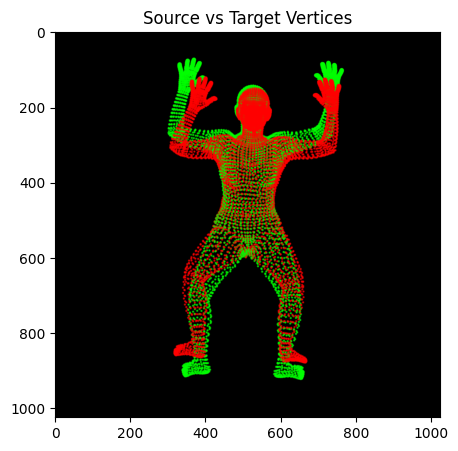

In [107]:
# As we can see, the source and target vertices
# are relatively close to each other

plt.figure(figsize=(5, 5))
plt.title("Source vs Target Vertices")
plt.imshow(yvsrc_trg)

In [ ]:
# @title Learn the deformation in the NN-based case
# define our deformation function

model = Siren(in_features=3,
                hidden_features=128,
                hidden_layers=3,
                out_features=3, outermost_linear=True,
                first_omega_0=30, hidden_omega_0=30.).to(DEVICE).train()

# you can adjust the AIAP weight based on your surface data:
# higher values of the AIAP_WEIGHT lead to a
# more isometric (constrained) learned deformation

AIAP_WEIGHT = 1.0e2
GUIDANCE_WEIGHT = 1.0e4

# start training

deform_cloud(model,
             xsrc=xsrc, xtrg=xtrg,
             vsrc=vsrc, vtrg=vtrg,
             init_lr=1.0e-4,
             n_steps=2000,
             aiap_weight=AIAP_WEIGHT,
             guided_weight=GUIDANCE_WEIGHT,
             use_chamfer=False,
             use_guidance=True,
             use_aiap=True,
             use_aiap_inter=True,
             device=DEVICE)

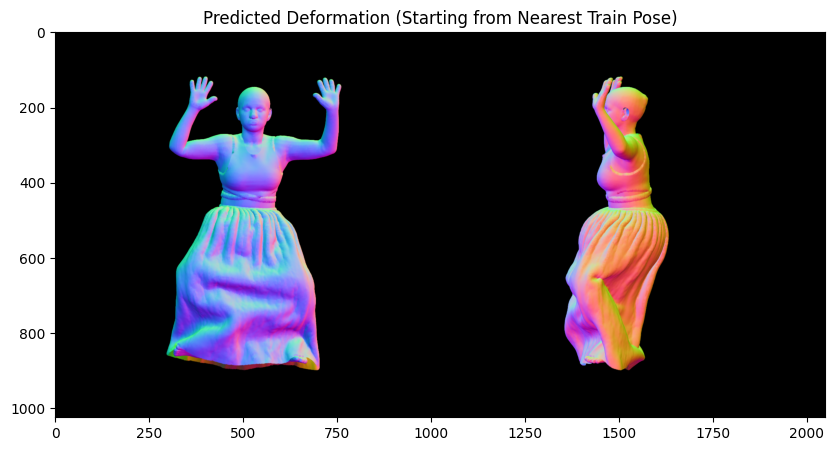

In [111]:
# @title Visualise predicted deformation for the NN-based case
# let's render our predicted deformed cloud

model.eval()

xpred = xsrc + model(xsrc).detach().clone()
xpred, npred = get_normals_pymeshlab(xpred.cpu().numpy(), k=20, smoothiter=0)

pcu.save_mesh_vn('predicted_nnbased.ply', xpred, npred)

xpred = torch.Tensor(xpred).to(DEVICE)
npred = torch.Tensor(npred).to(DEVICE)

npred_rgb = normals_to_rgb(npred) # we might need to flip the normal sign

ypred0 = render_points(xpred, npred_rgb, azim=0).detach().cpu().numpy()
ypred1 = render_points(xpred, npred_rgb, azim=90).detach().cpu().numpy()

y = np.hstack([ypred0, ypred1])

plt.figure(figsize=(10, 5))
plt.title("Predicted Deformation (Starting from Nearest Train Pose)")
plt.imshow(y)

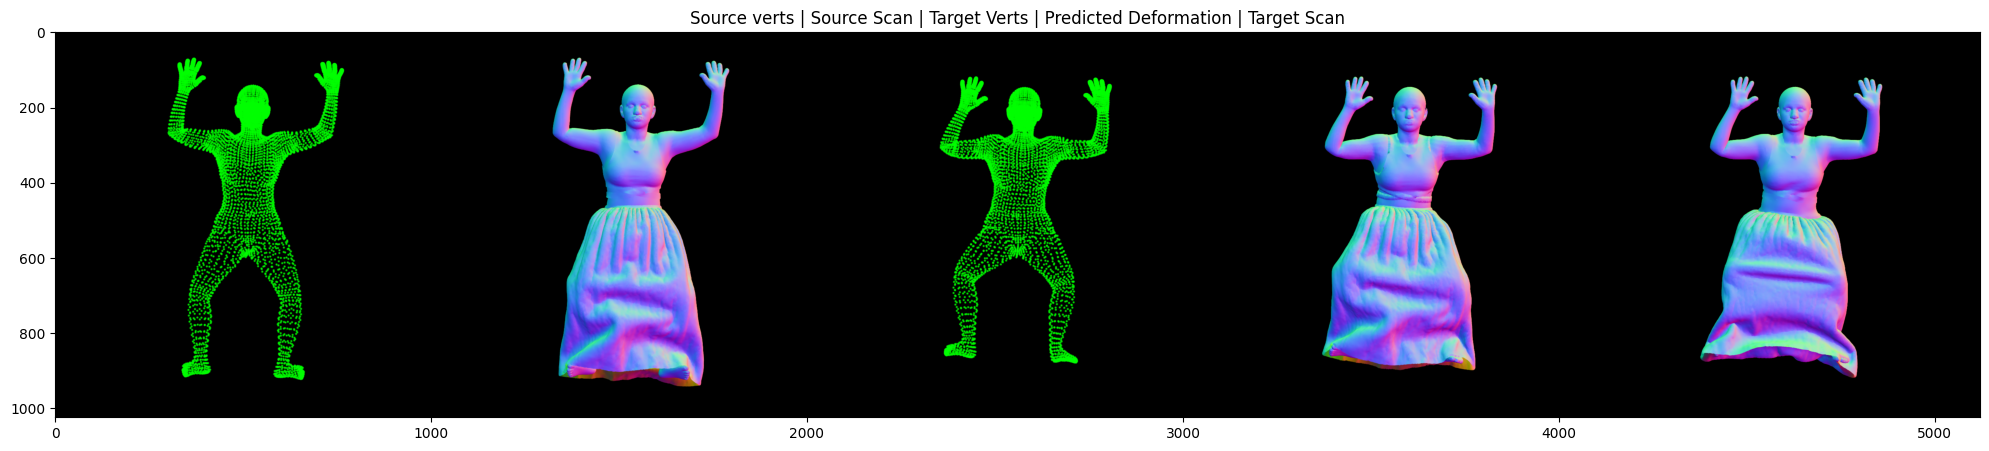

In [112]:
# @title Compare source, deformed and target scans (NN case)
# Let's visualise and compare source, predicted, and target scans
y = np.hstack([yvsrc, yxsrc, yvtrg, ypred0, yxtrg]).clip(0,1)

plt.figure(figsize=(25, 5))
plt.title("Source verts | Source Scan | Target Verts | Predicted Deformation | Target Scan")
plt.imshow(y)

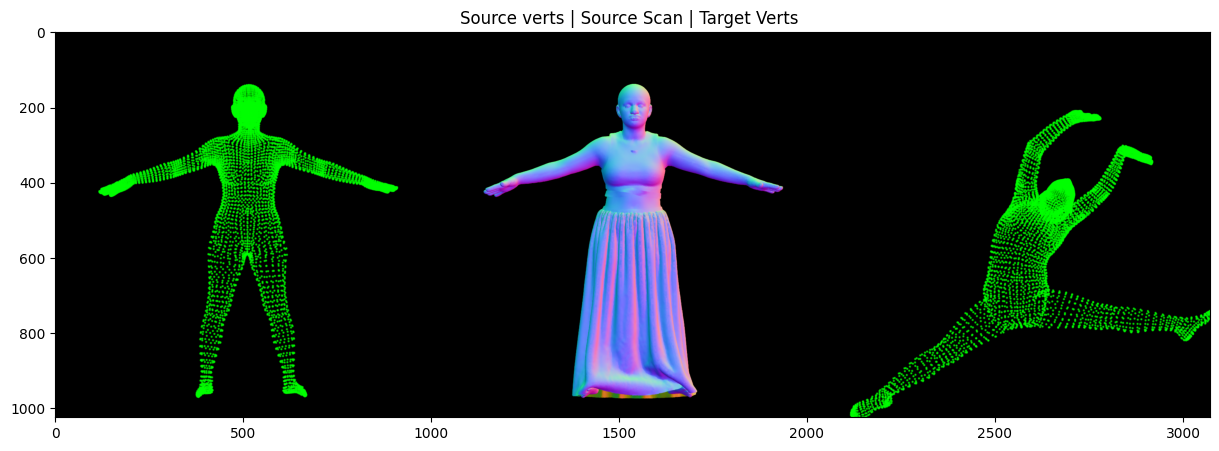

In [114]:
# @title Finally, let's learn the deformation in the case of some extreme target pose

xsrc, nsrc = pcu.load_mesh_vn('/content/source_apose.ply')

vsrc = pcu.load_mesh_v('/content/source_apose_vertices.ply')
vtrg = pcu.load_mesh_v('/content/extreme_pose_1.ply')

xsrc = torch.Tensor(xsrc).to(DEVICE)
csrc = normals_to_rgb(torch.Tensor(nsrc))
xtrg = torch.Tensor(xtrg).to(DEVICE)
ctrg = normals_to_rgb(torch.Tensor(ntrg))

vsrc = torch.Tensor(vsrc).to(DEVICE)
vtrg = torch.Tensor(vtrg).to(DEVICE)

# define colors for verts
vrgb = torch.zeros([len(vsrc), 3]).to(DEVICE)
vrgb[:, 1] = 1

yxsrc = render_points(xsrc, csrc).detach().cpu().numpy()
yvsrc = render_points(vsrc, VRGB_GREEN).detach().cpu().numpy()
yvtrg = render_points(vtrg, VRGB_GREEN).detach().cpu().numpy()

y = np.hstack([yvsrc, yxsrc, yvtrg]).clip(0,1)

plt.figure(figsize=(15, 5))
plt.title("Source verts | Source Scan | Target Verts ")
plt.imshow(y)

In [ ]:
# @title Deformation learning (Extreme pose)
# define our deformation function

model = Siren(in_features=3,
                hidden_features=128,
                hidden_layers=3,
                out_features=3, outermost_linear=True,
                first_omega_0=30, hidden_omega_0=30.).to(DEVICE).train()

# you can adjust the AIAP weight based on your surface data:
# higher values of the AIAP_WEIGHT lead to a
# more isometric (constrained) learned deformation

AIAP_WEIGHT = 1.0e2
GUIDANCE_WEIGHT = 1.0e4

# start training

deform_cloud(model,
             xsrc=xsrc, xtrg=xtrg,
             vsrc=vsrc, vtrg=vtrg,
             init_lr=1.0e-4,
             n_steps=2000,
             aiap_weight=AIAP_WEIGHT,
             guided_weight=GUIDANCE_WEIGHT,
             use_chamfer=False,
             use_guidance=True,
             use_aiap=True,
             use_aiap_inter=True,
             device=DEVICE)

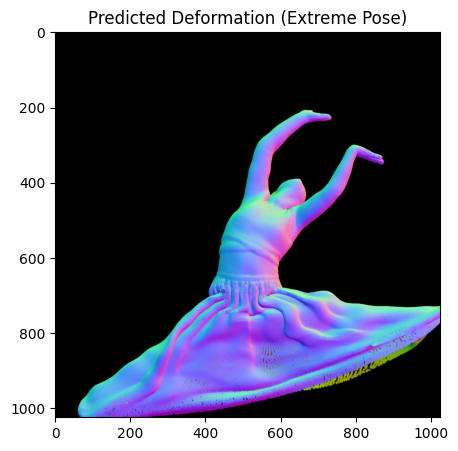

In [118]:
# @title Visualise predicted deformation for the extreme pose case

model.eval()

xpred = xsrc + model(xsrc).detach().clone()
xpred, npred = get_normals_pymeshlab(xpred.cpu().numpy(), k=30, smoothiter=0)

pcu.save_mesh_vn('predicted_extreme.ply', xpred, npred)

xpred = torch.Tensor(xpred).to(DEVICE)
npred = torch.Tensor(npred).to(DEVICE)

npred_rgb = normals_to_rgb(npred)

ypred0 = render_points(xpred, npred_rgb, azim=0).detach().cpu().numpy()

y = np.hstack([ypred0])

plt.figure(figsize=(10, 5))
plt.title("Predicted Deformation (Extreme Pose)")
plt.imshow(y)